This class uses the integral kernel to make DP predictions

In [1]:
import dp4gp_datasets
import dp4gp
import dp4gp_histogram

import random
import numpy as np
import GPy
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
c = pd.read_csv('price_dataset10k.csv')
#c = c.ix[random.sample(c.index, 4000)]

#east, north, time, education -> price
training_inputs = np.vstack([c['easting'].values,c['northing'].values]).T #c['seconds'].values)#,(c['QS501EW_6']/c['QS501EW_0']).values]).T
ys = c['price'].values

training_inputs = training_inputs[c['years'].values>2015,:]
ys = ys[c['years'].values>2015]

sens = 1e6
ys[ys>sens] = sens #threshold to make sensitivity manageable

Xtest, free_inputs, step = dp4gp.compute_Xtest(training_inputs,steps=10)

warning in stationary: failed to import cython module: falling back to numpy


In [2]:
dpgp = dp4gp_histogram.DPGP_histogram(sens,100.0,0.01)
dpgp.prepare_model(Xtest,training_inputs,step,ys,lengthscale=[3e3,3e3])
dpgp.optimize()

In [3]:
p,c = dpgp.draw_prediction_sample(np.array([[520e3,240e3]]))

In [4]:
dpgp.model.predict(np.array([[520e3,0,180e3,0]]))

(array([[ 282953.30488385]]), array([[  2.21372850e+08]]))

 /home/lionfish/anaconda2/lib/python2.7/site-packages/matplotlib/figure.py:1744: UserWarning:This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.


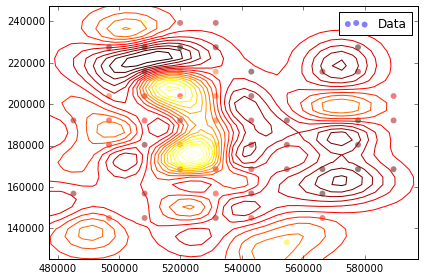

In [5]:
dpgp.model.plot(fixed_inputs=[(1,0),(3,0)])